### T-test 

In [1]:
# from __future__ import print_function, division
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
import sys
import pandas as pd
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from keras_bert import load_vocabulary
import matplotlib.pyplot as plt

from scipy.stats import t
from scipy import stats
    
from methods.preprocessing import Preprocess
from methods.baseline import Baseline
from methods.retrieval import Retrieval
from approaches.deepQL_topics import run as deepql_topics_run

import _pickle as pickle

from methods.evaluation import Evaluation, EvaluationPrecision, EvaluationRecall, EvaluationFscore

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

In [2]:
DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
for TEST in [['deepQL_topics', 'deepTL_topics']]:
    recall = {}
    for MODEL in TEST:
        RANK =  os.path.join('data/processed', DOMAIN, TOKEN, 'exported_rank_{}_1000.txt'.format(MODEL))
        evaluate = Evaluation(0)
        evaluate.evaluate(RANK)
        report = evaluate.get_recalls()
        recall[MODEL] = report
recall

{'deepQL_topics': {'0 - recall_at_1': [1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1

In [63]:
position = '0'
recall_at = '1'
y_train = np.array(range(len(recall['deepQL_topics']['{} - recall_at_{}'.format(position, recall_at)])))
y_test = np.array(range(len(recall['deepTL_topics']['{} - recall_at_{}'.format(position, recall_at)])))
A_score = np.array(recall['deepQL_topics']['{} - recall_at_{}'.format(position, recall_at)])
B_score = np.array(recall['deepTL_topics']['{} - recall_at_{}'.format(position, recall_at)])


y = np.concatenate([y_train, y_test])

(array([6364.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 5393.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 15 Patch objects>)

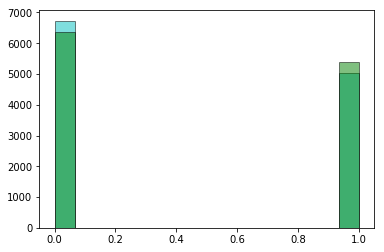

In [64]:
plt.hist(A_score, bins=15, color='c', edgecolor='k', alpha=0.5)
plt.hist(B_score, bins=15, color='g', edgecolor='k', alpha=0.5)

In [65]:
_, Pvalue = stats.ttest_rel(A_score, B_score)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.2209045123694927e-14
reject null hypothesis True


In [66]:
_, Pvalue = stats.wilcoxon(A_score, B_score)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.3127710449836274e-14
reject null hypothesis True


In [67]:
dup_method_A = [x for x in A_score if x == 1.0]
dup_method_B = [x for x in B_score if x == 1.0]

qtd_dup_method_A = len(dup_method_A)
qtd_dup_method_B = len(dup_method_B)
qtd_non_dup_method_A = len(A_score) - qtd_dup_method_A
qtd_non_dup_method_B = len(B_score) - qtd_dup_method_B

# A_score_table = [qtd_non_dup_method_A / len(A_score), qtd_dup_method_A / len(A_score)]
# B_score_table = [qtd_non_dup_method_B / len(B_score), qtd_dup_method_B / len(B_score)]

A_score_table = np.array([qtd_dup_method_A, qtd_non_dup_method_A], float)
B_score_table = np.array([qtd_dup_method_B, qtd_non_dup_method_B], float)

A_score_table, B_score_table

(array([5026., 6731.]), array([5393., 6364.]))

In [68]:
_, Pvalue = stats.fisher_exact([A_score_table, B_score_table], alternative='two-sided')
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.5457214673558431e-06
reject null hypothesis True


In [69]:
_, Pvalue = stats.chisquare(A_score_table, B_score_table)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.101544712566169e-11
reject null hypothesis True


## Calculate statistical results for retrieval

In [18]:
method_dict = {
    'baseline' : 'DMS',
    'baseline_dwen' : 'DWEN',
    'deepQL_topics' : 'SiameseQAT-A',
    'deepQL_topics_trainable' : 'SiameseQAT-W',
    'deepQL_weights' : 'SiameseQA-W',
    'deepQL_no_trainable' : 'SiameseQA-A',
    'deepQL_trainable' : 'SiameseQA-W',
    'deepTL' : 'SiameseTA',
    'deepTL_topics' : 'SiameseTAT'
}

In [28]:
# DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)

result = []

for DOMAIN in ['eclipse', 'netbeans', 'openoffice']:

    for TEST in [['deepQL_topics', 'deepQL_topics_trainable'],
                ['deepQL_topics', 'deepTL_topics'], ['deepQL_topics', 'deepTL'], ['deepQL_topics', 'deepQL_no_trainable'], 
                ['deepQL_topics', 'deepQL_trainable'], ['deepQL_topics', 'baseline'], ['deepQL_topics', 'baseline_dwen']]:
        recall = {}
        for MODEL in TEST:
            RANK =  os.path.join('data/processed', DOMAIN, TOKEN, 'exported_rank_{}_1000.txt'.format(MODEL))
            evaluate = Evaluation(0)
            evaluate.evaluate(RANK)
            report = evaluate.get_recalls()
            recall[MODEL] = report

        for position, recall_at in enumerate(['1', '5', '10', '15', '20', '25']):
            method_a, method_b = TEST
            y_train = np.array(range(len(recall[method_a]['{} - recall_at_{}'.format(position, recall_at)])))
            y_test = np.array(range(len(recall[method_b]['{} - recall_at_{}'.format(position, recall_at)])))
            A_score = np.array(recall[method_a]['{} - recall_at_{}'.format(position, recall_at)])
            B_score = np.array(recall[method_b]['{} - recall_at_{}'.format(position, recall_at)])


            y = np.concatenate([y_train, y_test])

            Dvalue = round(np.mean(A_score - B_score), 2)
            gain = abs(round((np.mean(B_score) - np.mean(A_score)) /  np.mean(B_score) * 100.0, 2))

            # T-test
            _, Pvalue = stats.ttest_rel(A_score, B_score)
            result.append([method_dict[method_a], method_dict[method_b], recall_at, Pvalue < 0.05, Pvalue, Dvalue, gain, 't-test', DOMAIN])
        
df = pd.DataFrame(result, columns=['A', 'B', 'recall_at', 'significant', 'p_value', 'd_value', 'gain', 'test', 'domain'])

In [31]:
df[df['domain'] == 'eclipse']

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
0,SiameseQAT-A,SiameseQAT-W,1,True,3.160717e-02,0.01,1.44,t-test,eclipse
1,SiameseQAT-A,SiameseQAT-W,5,True,3.059200e-03,0.01,1.46,t-test,eclipse
2,SiameseQAT-A,SiameseQAT-W,10,True,9.652760e-04,0.01,1.48,t-test,eclipse
3,SiameseQAT-A,SiameseQAT-W,15,True,9.279971e-05,0.01,1.67,t-test,eclipse
4,SiameseQAT-A,SiameseQAT-W,20,True,1.047995e-05,0.01,1.83,t-test,eclipse
5,SiameseQAT-A,SiameseQAT-W,25,True,1.153677e-05,0.01,1.79,t-test,eclipse
6,SiameseQAT-A,SiameseTAT,1,True,3.290719e-06,0.01,3.16,t-test,eclipse
7,SiameseQAT-A,SiameseTAT,5,True,2.384715e-05,0.01,2.11,t-test,eclipse
8,SiameseQAT-A,SiameseTAT,10,True,8.202227e-04,0.01,1.52,t-test,eclipse
9,SiameseQAT-A,SiameseTAT,15,True,1.769518e-04,0.01,1.61,t-test,eclipse


In [32]:
df[df['domain'] == 'netbeans']

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
42,SiameseQAT-A,SiameseQAT-W,1,False,2.117887e-01,0.00,0.66,t-test,netbeans
43,SiameseQAT-A,SiameseQAT-W,5,True,2.139470e-02,0.01,0.95,t-test,netbeans
44,SiameseQAT-A,SiameseQAT-W,10,False,1.572312e-01,0.00,0.54,t-test,netbeans
45,SiameseQAT-A,SiameseQAT-W,15,False,1.912398e-01,0.00,0.48,t-test,netbeans
46,SiameseQAT-A,SiameseQAT-W,20,False,7.549774e-02,0.00,0.63,t-test,netbeans
47,SiameseQAT-A,SiameseQAT-W,25,False,2.460283e-01,0.00,0.40,t-test,netbeans
48,SiameseQAT-A,SiameseTAT,1,True,4.109826e-07,0.01,2.82,t-test,netbeans
49,SiameseQAT-A,SiameseTAT,5,True,7.904401e-08,0.01,2.28,t-test,netbeans
50,SiameseQAT-A,SiameseTAT,10,True,1.375409e-05,0.01,1.70,t-test,netbeans
51,SiameseQAT-A,SiameseTAT,15,True,3.788108e-04,0.01,1.34,t-test,netbeans


In [33]:
df[df['domain'] == 'openoffice']

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
84,SiameseQAT-A,SiameseQAT-W,1,True,1.404013e-03,-0.01,2.86,t-test,openoffice
85,SiameseQAT-A,SiameseQAT-W,5,True,1.514569e-03,-0.01,2.14,t-test,openoffice
86,SiameseQAT-A,SiameseQAT-W,10,False,9.197986e-02,-0.01,1.04,t-test,openoffice
87,SiameseQAT-A,SiameseQAT-W,15,True,3.295286e-02,-0.01,1.26,t-test,openoffice
88,SiameseQAT-A,SiameseQAT-W,20,True,3.220660e-02,-0.01,1.21,t-test,openoffice
89,SiameseQAT-A,SiameseQAT-W,25,False,8.312350e-02,-0.01,0.96,t-test,openoffice
90,SiameseQAT-A,SiameseTAT,1,True,1.220905e-14,-0.03,6.81,t-test,openoffice
91,SiameseQAT-A,SiameseTAT,5,True,1.862192e-17,-0.03,5.60,t-test,openoffice
92,SiameseQAT-A,SiameseTAT,10,True,1.220304e-16,-0.03,4.93,t-test,openoffice
93,SiameseQAT-A,SiameseTAT,15,True,3.189558e-17,-0.03,4.74,t-test,openoffice


## Calculate statistical results for classification

In [5]:
def load_result(name):
    with open(os.path.join(DIR,'{}.pkl'.format(name)), 'rb') as f:
        return pickle.load(f)

In [35]:
# DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)

result = []



# ['deepQL_topics', 'baseline_dwen'], ['deepQL_topics', 'baseline'],
#                  ['deepTL_topics', 'baseline_dwen'], ['deepTL_topics', 'baseline'], 
#                  ['deepQL_no_trainable', 'baseline_dwen'], ['deepQL_no_trainable', 'baseline'],
#                  ['deepQL_trainable', 'baseline_dwen'], ['deepQL_trainable', 'baseline'],
#                  ['deepTL', 'baseline_dwen'], ['deepTL', 'baseline'],
#                  ['deepQL_topics', 'baseline_dwen'], ['deepQL_topics', 'baseline']

for DOMAIN in ['eclipse', 'netbeans', 'openoffice']: 

    for TEST in [['deepQL_topics', 'deepQL_topics_trainable'],
                 ['deepQL_topics', 'deepTL_topics'], ['deepQL_topics', 'deepTL'],
                 ['deepQL_topics', 'deepQL_no_trainable'], 
                 ['deepQL_topics', 'deepQL_trainable'], ['deepQL_topics', 'baseline_dwen'],
                 ['deepQL_topics', 'baseline']]:
        acc = {}
        for MODEL in TEST:
            
            name = '{}_1000_classification'.format(MODEL)
            report = load_result(name)
            
            acc[MODEL] = report['acc']

        method_a, method_b = TEST
        y_train = np.array(range(len(acc[method_a])))
        y_test = np.array(range(len(acc[method_b])))
        A_score = np.array(acc[method_a])
        B_score = np.array(acc[method_b])
            
        y = np.concatenate([y_train, y_test])

        Dvalue = round(np.mean(A_score - B_score), 2)
        gain = abs(round((np.mean(B_score) - np.mean(A_score)) /  np.mean(B_score) * 100.0, 2))

        # T-test
        _, Pvalue = stats.mstats.ttest_ind(A_score, B_score)
        result.append([method_dict[method_a], method_dict[method_b], Pvalue < 0.05, Pvalue, Dvalue, gain, 't-test', DOMAIN])
        
df = pd.DataFrame(result, columns=['A', 'B', 'significant', 'p_value', 'd_value', 'gain', 'test', 'domain'])

In [36]:
df[df['domain'] == 'eclipse']

,A,B,significant,p_value,d_value,gain,test,domain
0,SiameseQAT-A,SiameseQAT-W,True,9.558379e-239,0.04,4.86,t-test,eclipse
1,SiameseQAT-A,SiameseTAT,False,4.506579e-01,0.00,0.09,t-test,eclipse
2,SiameseQAT-A,SiameseTA,True,1.911344e-75,0.02,2.48,t-test,eclipse
3,SiameseQAT-A,SiameseQA-A,True,1.125425e-26,0.01,1.37,t-test,eclipse
4,SiameseQAT-A,SiameseQA-W,True,2.668848e-33,0.01,1.56,t-test,eclipse
5,SiameseQAT-A,DWEN,True,0.000000e+00,0.25,36.45,t-test,eclipse
6,SiameseQAT-A,DMS,True,4.008392e-205,0.04,4.43,t-test,eclipse


In [37]:
df[df['domain'] == 'netbeans']

,A,B,significant,p_value,d_value,gain,test,domain
7,SiameseQAT-A,SiameseQAT-W,True,9.558379e-239,0.04,4.86,t-test,netbeans
8,SiameseQAT-A,SiameseTAT,False,4.506579e-01,0.00,0.09,t-test,netbeans
9,SiameseQAT-A,SiameseTA,True,1.911344e-75,0.02,2.48,t-test,netbeans
10,SiameseQAT-A,SiameseQA-A,True,1.125425e-26,0.01,1.37,t-test,netbeans
11,SiameseQAT-A,SiameseQA-W,True,2.668848e-33,0.01,1.56,t-test,netbeans
12,SiameseQAT-A,DWEN,True,0.000000e+00,0.25,36.45,t-test,netbeans
13,SiameseQAT-A,DMS,True,4.008392e-205,0.04,4.43,t-test,netbeans


In [38]:
df[df['domain'] == 'openoffice']

,A,B,significant,p_value,d_value,gain,test,domain
14,SiameseQAT-A,SiameseQAT-W,True,9.558379e-239,0.04,4.86,t-test,openoffice
15,SiameseQAT-A,SiameseTAT,False,4.506579e-01,0.00,0.09,t-test,openoffice
16,SiameseQAT-A,SiameseTA,True,1.911344e-75,0.02,2.48,t-test,openoffice
17,SiameseQAT-A,SiameseQA-A,True,1.125425e-26,0.01,1.37,t-test,openoffice
18,SiameseQAT-A,SiameseQA-W,True,2.668848e-33,0.01,1.56,t-test,openoffice
19,SiameseQAT-A,DWEN,True,0.000000e+00,0.25,36.45,t-test,openoffice
20,SiameseQAT-A,DMS,True,4.008392e-205,0.04,4.43,t-test,openoffice
